In [1]:
import pickle
with open('artist_docs2.pkl', 'rb') as f:
    all_tracks= pickle.load(f)
print(len(all_tracks))

418994


In [4]:
import pandas as pd
all_df = pd.DataFrame(all_tracks)
all_df.count()

artist1    418994
artist2    418994
url        418994
dtype: int64

In [5]:
import networkx as nx

G = nx.Graph()
for i in range(len(all_df)):
    
    artist1 = all_df.iloc[i]['artist1']
    artist2 = all_df.iloc[i]['artist2']
    
    if ('&' not in artist1) and ('&' not in artist2):
        
        if not G.has_node(artist1):
            G.add_node(artist1)
        if not G.has_node(artist2):
            G.add_node(artist2)
        if not G.has_edge(artist1,artist2):
            G.add_edge(artist1, artist2, weight=1)
        else:
            try:
                G[artist1][artist2]['weight'] += 1
            except:
                print(G[artist1][artist2])
                break

print(G.number_of_edges())
print(G.number_of_nodes())

159091
9378


In [6]:
nx.shortest_path(G, 'Lane 8', 'deadmau5', weight='weight')

['Lane 8', 'Krystal Klear', 'deadmau5']

In [7]:
import numpy as np

weights = []
for i in range(len(all_df)):
    
    artist1 = all_df.iloc[i]['artist1']
    artist2 = all_df.iloc[i]['artist2']
    
    if ('&' not in artist1) and ('&' not in artist2):
        weights.append(G[artist1][artist2]['weight'])
    
print(np.max(weights))
print(np.mean(weights))

165
2.356849160476139


In [8]:
max_weight = np.max(weights)
print(max_weight)

165


In [9]:
pairs = []
for i in range(len(all_df)):
    
    artist1 = all_df.iloc[i]['artist1']
    artist2 = all_df.iloc[i]['artist2']
    
    if ('&' not in artist1) and ('&' not in artist2):
        pairs.append(tuple((artist1,artist2)))
    
print(len(set(pairs)))
pairs = set(pairs)

168651


In [10]:
G_new = G.copy()

new_weights = []
for pair in pairs:
    
    artist1 = pair[0]
    artist2 = pair[1]
    
    if ('&' not in artist1) and ('&' not in artist2):
        
        # Invert and normalize weights
        new_weights.append(1. - (G_new[artist1][artist2]['weight'] / max_weight))

        G_new[artist1][artist2]['weight'] = 1. - (G[artist1][artist2]['weight'] / float(max_weight))

In [11]:
# Shortest path Lane 8 -- deadmau5           
print(nx.shortest_path(G_new, 'Lane 8', 'deadmau5', weight='weight'))

['Lane 8', 'FISHER', 'deadmau5']


In [12]:
# Shortest path Lane 8 -- Kryder          
print(nx.shortest_path(G_new, 'Lane 8', 'Kryder', weight='weight'))

['Lane 8', 'Justice', 'Kryder']


In [13]:
# Shortest path Lane 8 -- Above & Beyond          
print(nx.shortest_path(G_new, 'Lane 8', 'ALPHA 9', weight='weight'))

['Lane 8', 'FISHER', 'Daft Punk', 'ALPHA 9']


### It definitely abuses nodes that represent artists that are probably played constantly (i.e. Pryda/Prydz)
- Weight by inverse representation of artists on both sides of edge could fix this

In [14]:
from collections import Counter

all_artists = np.append(all_df['artist1'], all_df['artist2'])
artist_weights = Counter(all_artists)

max_count = np.max(list(artist_weights.values()))
for key in artist_weights.keys():
    artist_weights[key] /= float(max_count)


In [15]:
G_weighted = G.copy()

weighted_weights  = [] #great var name
for pair in pairs:
    
    artist1 = pair[0]
    artist2 = pair[1]
    
    if ('&' not in artist1) and ('&' not in artist2):
        
        weighted_weights.append(\
                                (1. - (G[artist1][artist2]['weight'] / float(max_weight))) *\
                                                 artist_weights[artist1] * artist_weights[artist2]
                               )

        G_weighted[artist1][artist2]['weight'] = (1. - (G[artist1][artist2]['weight'] / float(max_weight))) *\
                                                 artist_weights[artist1] * artist_weights[artist2]

In [16]:
# Shortest path Lane 8 -- deadmau5 (priority to lesser known artist)     
print(nx.shortest_path(G_weighted, 'Lane 8', 'deadmau5', weight='weight'))

### FUCK YESSSSSSSS -- but not sure why we still have features getting thru...

['Lane 8', 'Harold-Alexis', 'Nuage', 'TSHA', 'Rampa', 'Maceo Plex ft. Maars', 'Alex Niggemann', 'ANOTR', 'Audion', 'Spencer Brown', 'Rinzen', 'FLIP-FLOP', 'deadmau5 X Mr. Bill', 'Electrocado ft. Sylvain Carton', 'deadmau5']


In [17]:
# Shortest path Lane 8 -- deadmau5 (priority to lesser known artist)     
print(nx.shortest_path(G_weighted, 'Lane 8', 'Kryder', weight='weight'))

### Dont know any of these motherfuckers

['Lane 8', 'Harold-Alexis', 'Nuage', 'Steve Hauschildt', 'KH', 'KMA Productions', 'Four Tet', 'Izzy Bizu', 'Digitalism', 'DNF', 'Kryder']


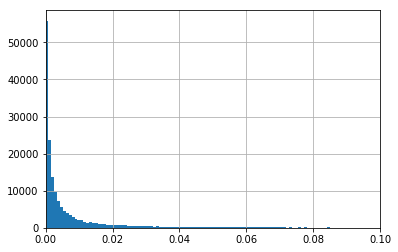

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline
ax = plt.hist(weighted_weights, bins=1000)
grid = plt.grid()
xlim = plt.xlim([0,.1])

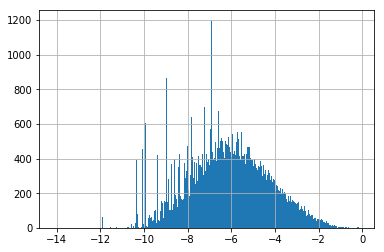

In [19]:
%matplotlib inline
ax = plt.hist([np.log(w) for w in weighted_weights if w != 0], bins=1000)
grid = plt.grid()

In [20]:
import numpy as np
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])
    
Str1 = "Lane 8"
Str2 = "Lane8"
Distance = levenshtein_ratio_and_distance(Str1,Str2)
print(Distance)
Ratio = levenshtein_ratio_and_distance(Str1,Str2,ratio_calc = True)
print(Ratio)

The strings are 1 edits away
0.9090909090909091


In [21]:
def node_match(string, graph):
    
    matches = []
    for node_name in list(graph.nodes()):
        ratio = levenshtein_ratio_and_distance(string.lower(),node_name.lower(),ratio_calc=True)
        matches.append((ratio,node_name))
        
    return sorted(matches, key=lambda x: x[0], reverse=True)[:10]

node_match('Joyryde', G_new)

[(1.0, 'JOYRYDE'),
 (0.7272727272727273, 'Jyye'),
 (0.6666666666666666, 'Rydel'),
 (0.6153846153846154, 'Jaydee'),
 (0.6153846153846154, 'Jordon'),
 (0.6153846153846154, 'Kryder'),
 (0.6153846153846154, 'Dorade'),
 (0.6086956521739131, 'JOYRYDE ft. GOLD'),
 (0.5714285714285714, 'Joyce Mercedes'),
 (0.5714285714285714, 'Orkidea')]

### Artist Library Clustering???
- Need to do this on the played by data

In [22]:
raw_nodes = sorted(list(artist_weights.items()), key=lambda x: x[1], reverse=True)
raw_nodes = [node[0] for node in raw_nodes]
raw_nodes = [node for node in raw_nodes if '&' not in node][:1000]
node_matrix = np.zeros((len(raw_nodes),len(raw_nodes)))
print(node_matrix.shape)

(1000, 1000)


In [23]:
for i in range(len(raw_nodes))[:]:
    for j in range(len(raw_nodes)):
        if i == j:
            node_matrix[i][j] = 0
        else:
            try:
                node_matrix[i][j] = G[raw_nodes[i]][raw_nodes[j]]['weight']
                #print(node_matrix[i][j])
            except:
                node_matrix[i][j] = 0

                
for i in range(len(raw_nodes))[:]:
    
    if np.sum(node_matrix[i,:]) == 0:
        pass
    else:
        node_matrix[i,:] /= np.sum(node_matrix[i,:])


In [24]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = TSNE(n_components=3).fit_transform(node_matrix)
#X = PCA(n_components=3).fit_transform(node_matrix)
X

array([[   5.623524 ,   26.167677 ,  -18.365719 ],
       [-194.49164  , -183.1434   , -289.9367   ],
       [-107.80626  ,  -46.342182 ,  139.24294  ],
       ...,
       [ -23.43249  ,   29.318003 ,   -4.6631594],
       [  37.03387  ,   41.93787  ,   44.31834  ],
       [ -39.824062 ,   71.81064  ,  -18.564856 ]], dtype=float32)

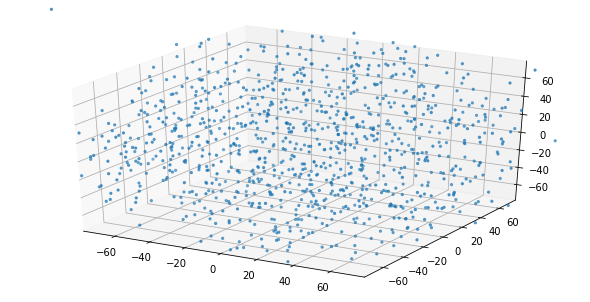

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(8,4))
ax = Axes3D(fig) 
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=5)

xlim = ax.set_xlim3d([-75,75])
ylim = ax.set_ylim3d([-75,75])
zlim = ax.set_zlim3d([-75,75])
# xlim = ax.set_xlim3d([-.03,.03])
# ylim = ax.set_ylim3d([-.03,.03])
# zlim = ax.set_zlim3d([-.03,.03])

Silhouette Coefficient 5: 0.426
Silhouette Coefficient 6: 0.402
Silhouette Coefficient 7: 0.402
Silhouette Coefficient 8: 0.382
Silhouette Coefficient 9: 0.381
Silhouette Coefficient 10: 0.390
Silhouette Coefficient 11: 0.374
Silhouette Coefficient 12: 0.383
Silhouette Coefficient 13: 0.391
Silhouette Coefficient 14: 0.377
Silhouette Coefficient 15: 0.402
Silhouette Coefficient 16: 0.387
Silhouette Coefficient 17: 0.394
Silhouette Coefficient 18: 0.391
Silhouette Coefficient 19: 0.393
Silhouette Coefficient 20: 0.393


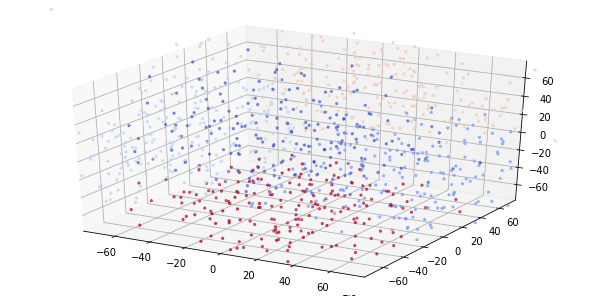

In [28]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics

for i in range(5,21):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    print("Silhouette Coefficient %d: %0.3f" % (i, metrics.silhouette_score(X, kmeans.labels_, metric='sqeuclidean')))

fig = plt.figure(figsize=(8,4))
ax = Axes3D(fig) 
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
colors = kmeans.labels_

ax = Axes3D(fig) #<-- Note the difference from your original code...
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=5, c=colors, cmap=plt.cm.coolwarm)

xlim = ax.set_xlim3d([-75,75])
ylim = ax.set_ylim3d([-75,75])
zlim = ax.set_zlim3d([-75,75])
# xlim = ax.set_xlim3d([-.03,.03])
# ylim = ax.set_ylim3d([-.03,.03])
# zlim = ax.set_zlim3d([-.03,.03])

Estimated number of clusters: 6
Silhouette Coefficient: 0.402


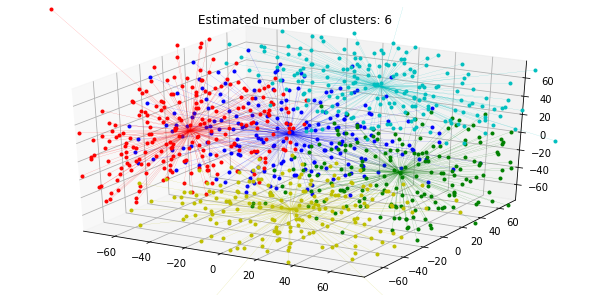

In [29]:
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import cycle

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

n_clusters_ = len(cluster_centers)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

fig = plt.figure(figsize=(8,4))
ax = Axes3D(fig) 

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[class_members, 0], X[class_members, 1], X[class_members, 2], col + '.')
    #plt.plot(cluster_center[0], cluster_center[1], cluster_center[2], 'o', markerfacecolor=col,
    #         markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        ax.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], [cluster_center[2], x[2]], col, linewidth=.1)

xlim = ax.set_xlim3d([-75,75])
ylim = ax.set_ylim3d([-75,75])
zlim = ax.set_zlim3d([-75,75])
# xlim = ax.set_xlim3d([-.03,.03])
# ylim = ax.set_ylim3d([-.03,.03])
# zlim = ax.set_zlim3d([-.03,.03])

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [30]:
cluster_df = pd.DataFrame([[raw_nodes[i], labels[i]] for i in range(len(raw_nodes))])
cluster_df.head(10)

,0,1
0,FISHER,0
1,Calvin Harris,4
2,Armin van Buuren,2
3,Drake,5
4,Axwell,5
5,Daft Punk,5
6,Tiesto,0
7,Zomboy,1
8,Purple Disco Machine,3
9,Diplo,0


In [31]:
cluster_df[cluster_df[1] == 0].head(10)

,0,1
0,FISHER,0
6,Tiesto,0
9,Diplo,0
16,Jack Back,0
17,BROHUG,0
25,Alesso,0
28,Jonas Aden ft. RebMoe,0
29,Malaa,0
30,Queen,0
37,Toby Green,0


In [32]:
cluster_df[cluster_df[1] == 1].head(10)

,0,1
7,Zomboy,1
12,Kanye West,1
19,Sheck Wes,1
27,RL Grime,1
35,Anna Lunoe,1
41,Eric Prydz,1
45,Nitti Gritti,1
46,Gammer,1
48,Panic! At The Disco,1
56,Virtual Riot,1


In [33]:
cluster_df[cluster_df[1] == 2].head(10)

,0,1
2,Armin van Buuren,2
15,Giuseppe Ottaviani,2
43,Sunstars,2
52,Dave Winnel,2
53,Yotto,2
64,Eptic,2
83,Jorn Van Deynhoven,2
86,The Prodigy,2
89,Rodg,2
98,Loud Luxury X Anders,2


In [34]:
cluster_df[cluster_df[1] == 3].head(10)

,0,1
8,Purple Disco Machine,3
14,Avicii ft. Aloe Blacc,3
21,Meduza ft. GOODBOYS,3
22,Pickle,3
24,Billie Eilish,3
36,Kideko,3
40,The Chemical Brothers,3
42,Joel Corry,3
47,Offaiah ft. Cat Connors,3
58,R\xc3\x9cF\xc3\x9cS DU SOL,3


In [35]:
cluster_df[cluster_df[1] == 4].head(10)

,0,1
1,Calvin Harris,4
940,Hardfloor,4
